# Public Notebook:
* https://www.kaggle.com/podsyp/nlp-with-simple-eda-kfold-svd-tf-idf-bland


# Competition Description

* https://www.kaggle.com/c/nlp-getting-started

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:
* https://twitter.com/AnyOtherAnnaK/status/629195955506708480

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. If this is your first time working on an NLP problem, we've created a quick tutorial to get you up and running.

Disclaimer: The dataset for this competition contains text that may be considered profane, vulgar, or offensive.

# Competition metric
Submissions are evaluated using F1 between the predicted and expected answers.

F1 is calculated as follows:
$$ F_1 = {2 * {precision*recall \over precision+recall}} $$


and:

$$ precision = {TP \over TP+FP} $$

$$ recall = {TP \over TP+FN} $$


* True Positive [TP] = your prediction is 1, and the ground truth is also 1 - you predicted a positive and that's true!
* False Positive [FP] = your prediction is 1, and the ground truth is 0 - you predicted a positive, and that's false.
* False Negative [FN] = your prediction is 0, and the ground truth is 1 - you predicted a negative, and that's false.

## Import

In [1]:
import collections
import unidecode
import re
import string

#!pip install pyspellchecker
from spellchecker import SpellChecker

import numpy as np 
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc, math
from tqdm import tqdm
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score, roc_curve

In [3]:
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

## Options

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('use_inf_as_na', True)

warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [5]:
%%time
folder = 'data/'
train_df = pd.read_csv(folder + 'train.csv')
test_df = pd.read_csv(folder + 'test.csv')
sub_df = pd.read_csv(folder + 'sample_submission.csv')

Wall time: 25 ms


# Simple EDA

In [6]:
print('train_df')
print('train: ', train_df.shape)
print('test_df')
print('test: ', test_df.shape)
print('sub_df')
print('sub_df: ', sub_df.shape)

train_df
train:  (7613, 5)
test_df
test:  (3263, 4)
sub_df
sub_df:  (3263, 2)


In [7]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

In [10]:
train_df.describe(include=['O'])

,keyword,location,text
count,7552,5080,7613
unique,221,3341,7503
top,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...
freq,45,104,10


In [11]:
test_df.describe(include=['O'])

,keyword,location,text
count,3237,2158,3263
unique,221,1602,3243
top,deluged,New York,11-Year-Old Boy Charged With Manslaughter of T...
freq,23,38,3


In [12]:
sub_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## Check some Null's

In [13]:
def missing_values_table(df, info=True):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        if info:
            print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
                "There are " + str(mis_val_table_ren_columns.shape[0]) +
                  " columns that have missing values.")
        return mis_val_table_ren_columns

In [14]:
print('Missing columns in train: ')
missing_values_table(train_df)

Missing columns in train: 
Your selected dataframe has 4 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
location,2533,33.3
keyword,61,0.8


In [15]:
print('Missing columns in test: ')
missing_values_table(test_df)

Missing columns in test: 
Your selected dataframe has 3 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
location,1105,33.9
keyword,26,0.8


### Fill it

In [16]:
for df_ in (train_df, test_df):
    df_['location'] = df_['location'].fillna('?')
    df_['keyword'] = df_['keyword'].fillna('?')

# Make mean target encoding for categorical feature

Let us consider the above table (A simple binary classification). 

$$ MeanTargetEnc_i = {((GlobalMean * C) + (Mean_i * Size)) \over (C + Size)} $$

Instead of finding the mean of the targets, we can also focus on median and other statistical correlations….These are broadly called target encodings

In [17]:
class MeanEncoding(BaseEstimator):
    """   In Mean Encoding we take the number 
    of labels into account along with the target variable 
    to encode the labels into machine comprehensible values    """
    
    def __init__(self, feature, C=0.1):
        self.C = C
        self.feature = feature
        
    def fit(self, X_train, y_train):
        
        df = pd.DataFrame({'feature': X_train[self.feature], 'target': y_train}).dropna()
        
        self.global_mean = df.target.mean()
        mean = df.groupby('feature').target.mean()
        size = df.groupby('feature').target.size()
        
        self.encoding = (self.global_mean * self.C + mean * size) / (self.C + size)
    
    def transform(self, X_test):
        
        X_test[self.feature] = X_test[self.feature].map(self.encoding).fillna(self.global_mean).values
        
        return X_test
    
    def fit_transform(self, X_train, y_train):
        
        df = pd.DataFrame({'feature': X_train[self.feature], 'target': y_train}).dropna()
        
        self.global_mean = df.target.mean()
        mean = df.groupby('feature').target.mean()
        size = df.groupby('feature').target.size()
        self.encoding = (self.global_mean * self.C + mean * size) / (self.C + size)
        
        X_train[self.feature] = X_train[self.feature].map(self.encoding).fillna(self.global_mean).values
        
        return X_train

In [18]:
for f in ['location', 'keyword']:
    me = MeanEncoding(f, C=0.01*len(train_df[f].unique()))
    me.fit(train_df, train_df['target'])
    train_df = me.transform(train_df)
    test_df = me.transform(test_df)

In [19]:
train_df.tail()

,keyword,location,text,target
7608,0.679434,0.424195,Two giant cranes holding a bridge collapse int...,1
7609,0.679434,0.424195,@aria_ahrary @TheTawniest The out of control w...,1
7610,0.679434,0.424195,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,0.679434,0.424195,Police investigating after an e-bike collided ...,1
7612,0.679434,0.424195,The Latest: More Homes Razed by Northern Calif...,1


In [20]:
test_df.tail()

,keyword,location,text
3258,0.679434,0.424195,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,0.679434,0.424195,Storm in RI worse than last hurricane. My city...
3260,0.679434,0.424195,Green Line derailment in Chicago http://t.co/U...
3261,0.679434,0.424195,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,0.679434,0.424195,#CityofCalgary has activated its Municipal Eme...


# Link Flag

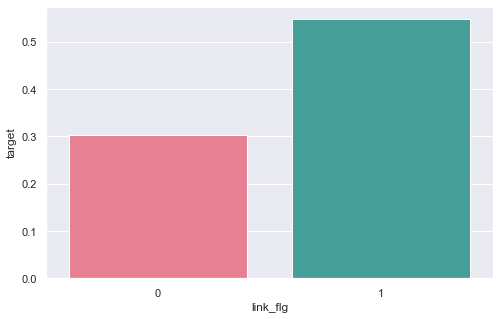

In [21]:
def link_flg(string):
    if 'http' in string.lower():
        return 1
    else:
        return 0

for df_ in (train_df, test_df):
    df_['link_flg'] = df_['text'].apply(link_flg)

tmp = train_df.groupby('link_flg').agg('mean')['target'].reset_index()
plt.figure(figsize=(8,5))
fig = sns.barplot(x=tmp['link_flg'], y=tmp['target'], palette="husl")

# Text preprocess for counts
- Remove accents. Instead of receiving accented characters (latté) we just write plain letters.
- Remove URL. Most tweets may include links and such, it may be good to clean them.
- Remove html. Scratched data usually contains headers and marks (<br/), this should be removed.

In [22]:
def remove_accented_chars(text):
    text = unidecode.unidecode(text)
    return text

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def text_preprocess(text):
    text = remove_accented_chars(text)
    text = remove_html(text)
    text = remove_url(text)
    return text

In [23]:
train_df['text'] = train_df['text'].apply(text_preprocess)
test_df['text'] = test_df['text'].apply(text_preprocess)

# Count len of tweets

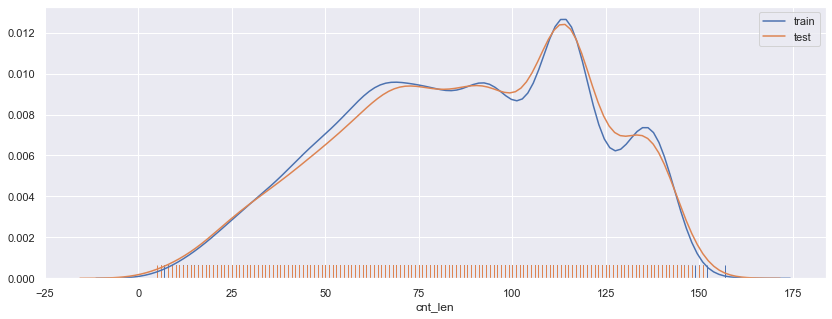

In [24]:
nm = 'cnt_len'
def cnt_len(string) -> int:
    return len(string)

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_len)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

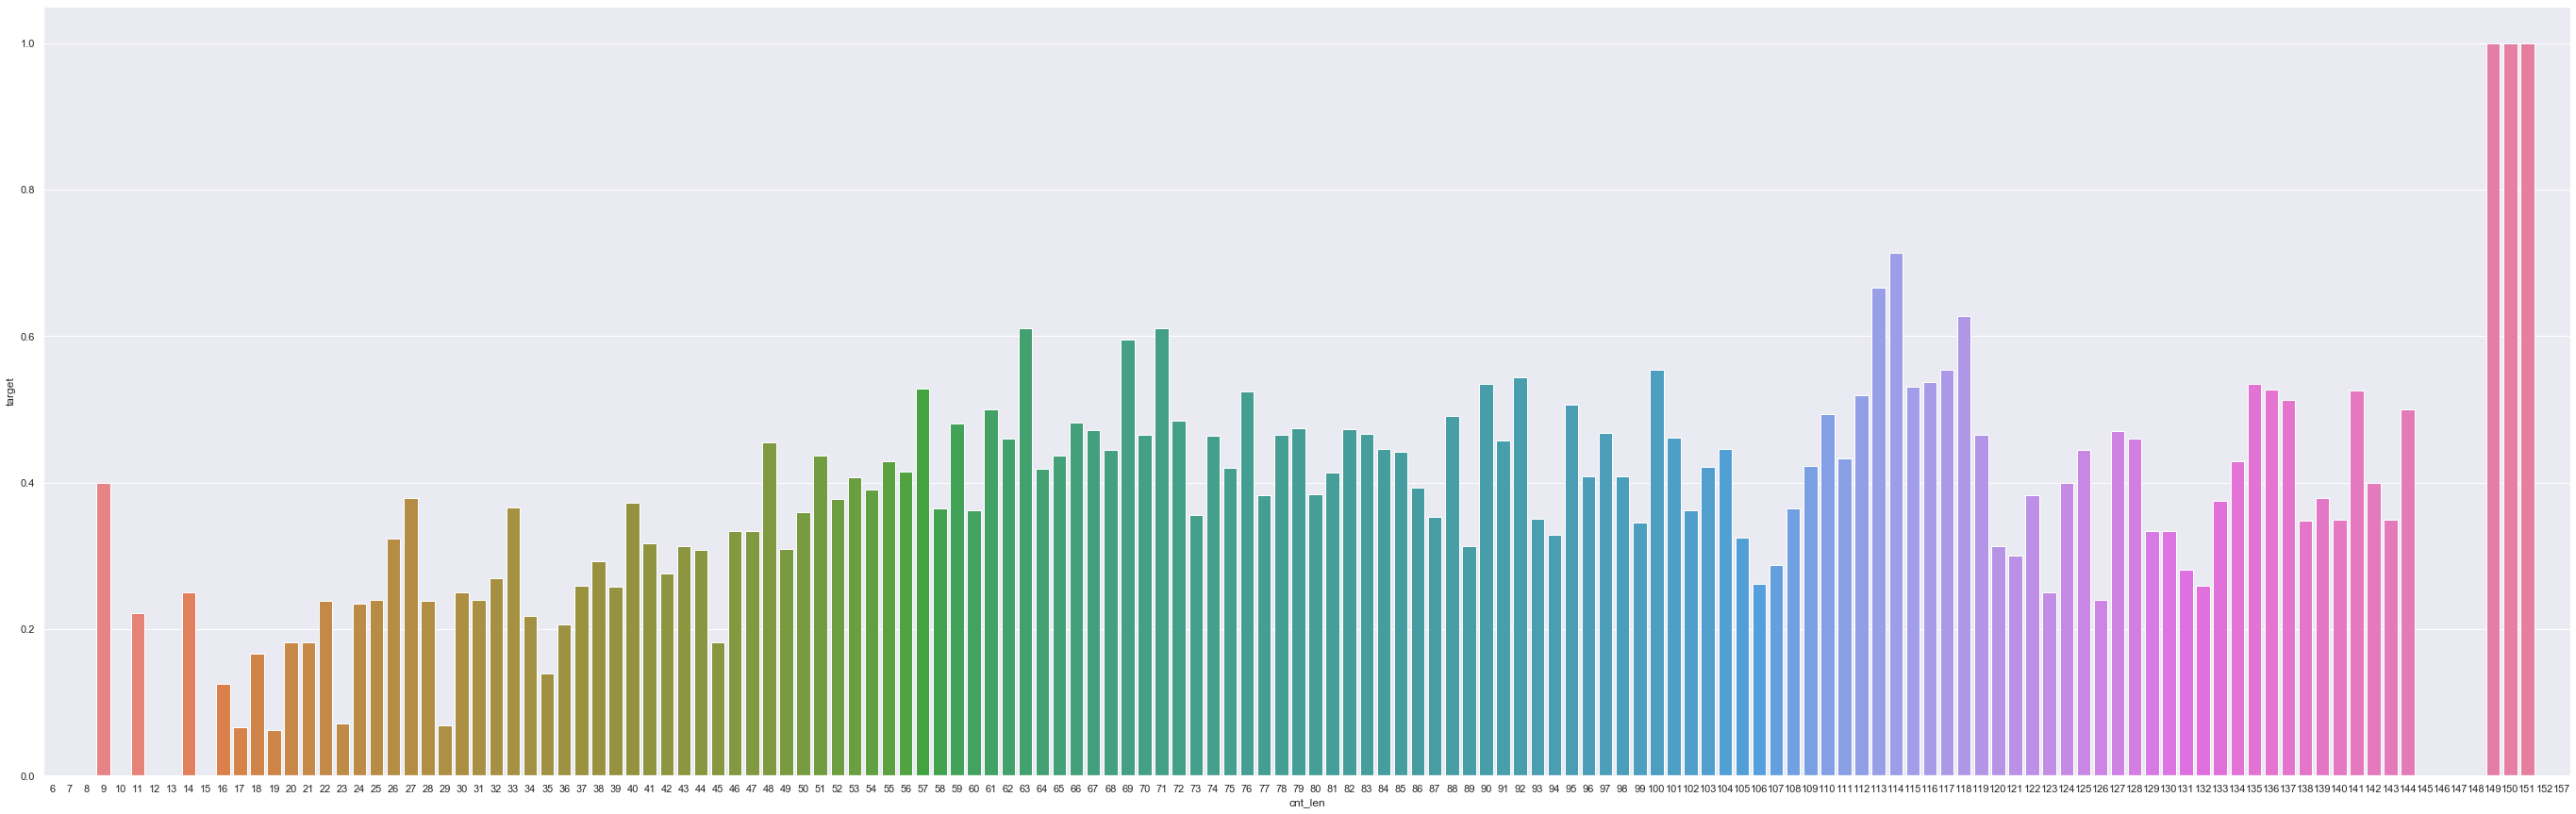

In [25]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(48,15))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count users by "@"

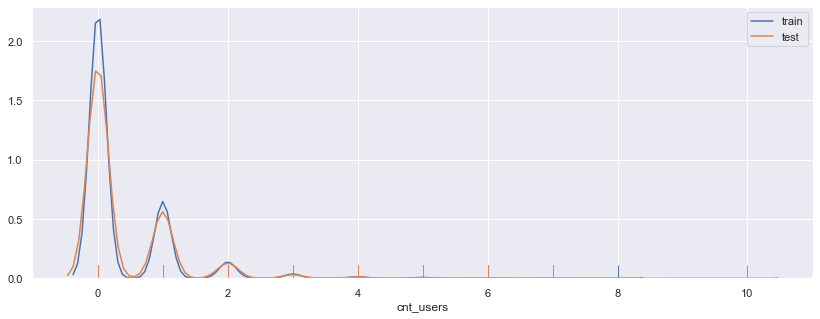

In [26]:
nm = 'cnt_users'
def cnt_users(string) -> int:
    return sum(list(map(lambda s: 1 if s == '@' else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_users)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

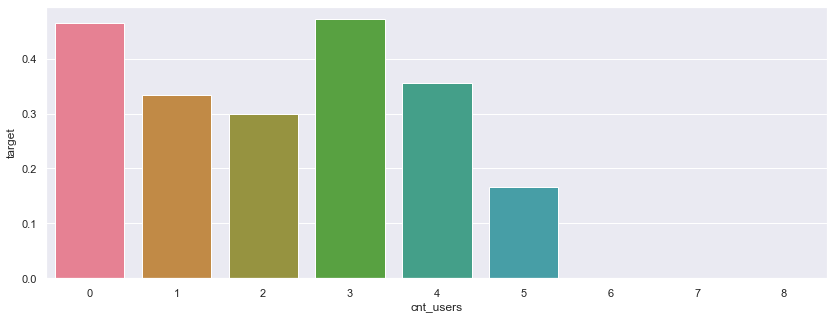

In [27]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(14,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count hashtags by "#"

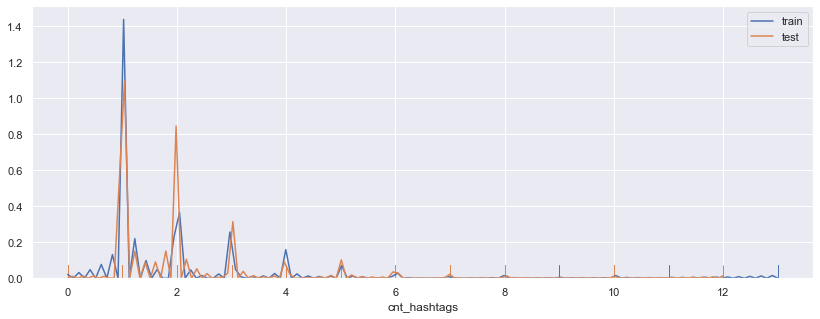

In [28]:
nm = 'cnt_hashtags'
def cnt_hashtags(string) -> int:
    return sum(list(map(lambda s: 1 if s == '#' else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_hashtags)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

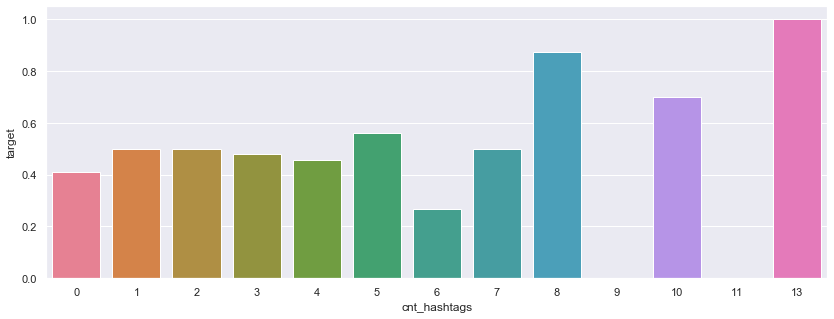

In [29]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(14,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count punctuation by:
## ".", ",", ":", ";", "!", "?", "(", ")", "/", "\\", "|", "\"", "\"", "-",  "«",  "»"

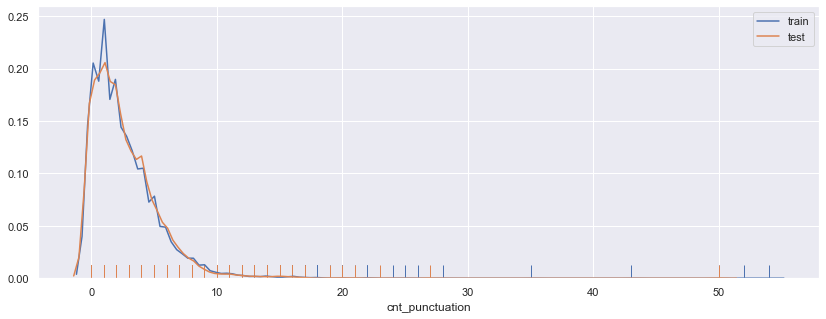

In [30]:
punctuation = ['.',',',':',';','!','?','(',')','/','\\','|','\"','\'','-', '«', '»']
nm = 'cnt_punctuation'

def cnt_punctuation(string) -> int:
    return sum(list(map(lambda s: 1 if s in punctuation else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_punctuation)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

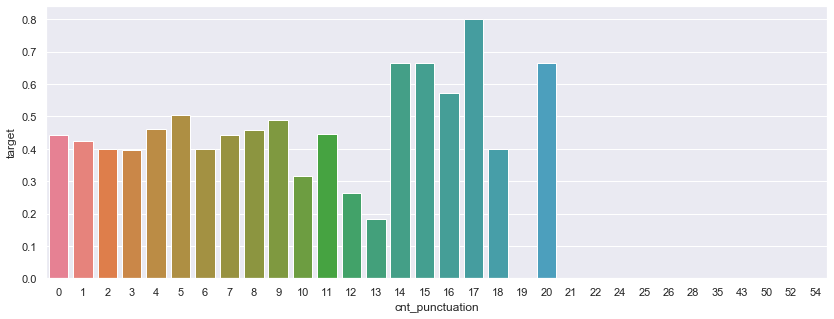

In [31]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(14,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count words by whitespaces

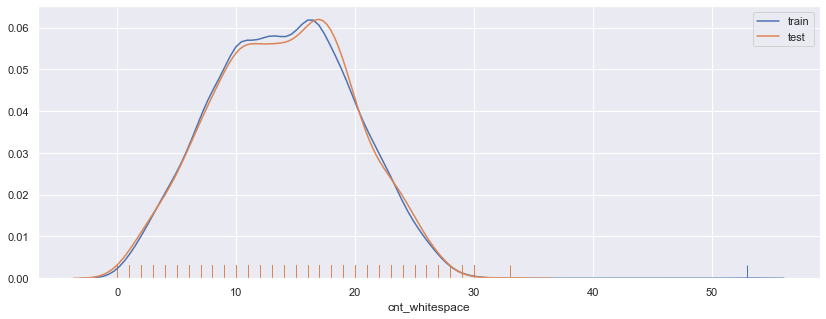

In [32]:
nm = 'cnt_whitespace'
def cnt_whitespace(string) -> int:
    return sum(list(map(lambda s: 1 if s == ' ' else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_whitespace)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

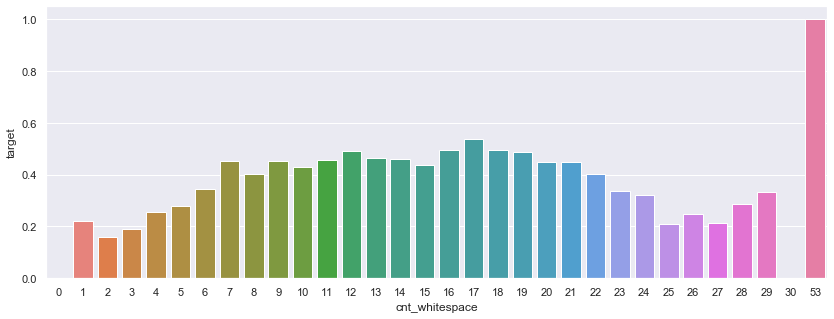

In [33]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(14,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count numeral in tweets

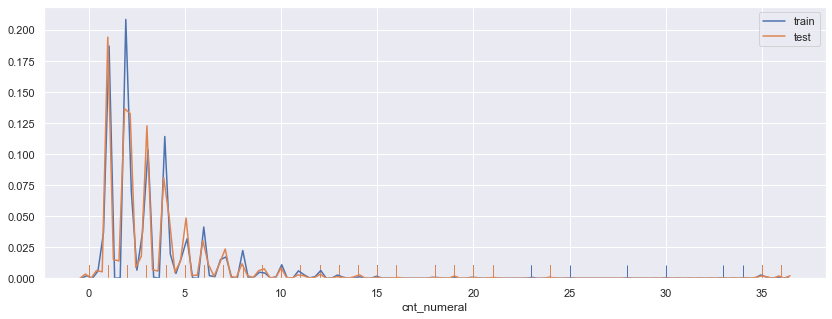

In [34]:
numeral = '1234567890'
nm = 'cnt_numeral'

def cnt_numeral(string) -> int:
    return sum(list(map(lambda s: 1 if s in numeral else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_numeral)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

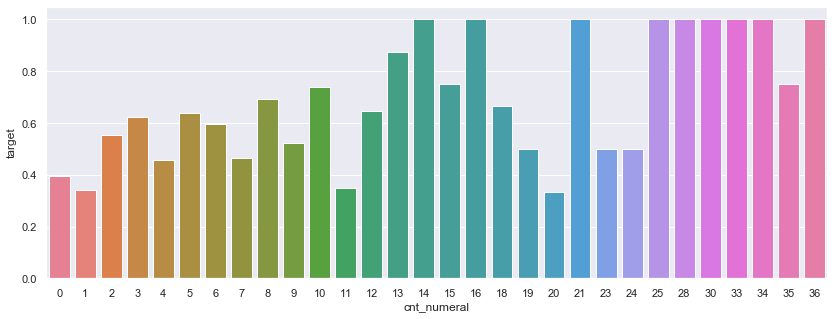

In [35]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(14,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count other symbols

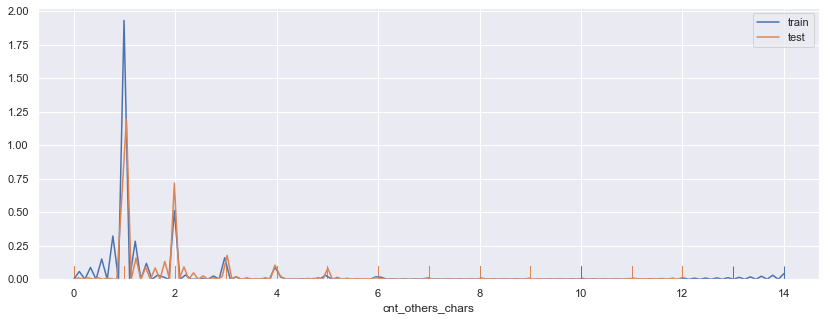

In [36]:
eng = 'abcdefghijklmnopqrstuvwxyz'
nm = 'cnt_others_chars'
def cnt_others_chars(string) -> int:
    return sum(list(map(lambda s: 1 if s != ' ' and s not in punctuation and s not in numeral and 
                        s != '#' and s != '@' and s not in eng and s not in eng.upper() else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_others_chars)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

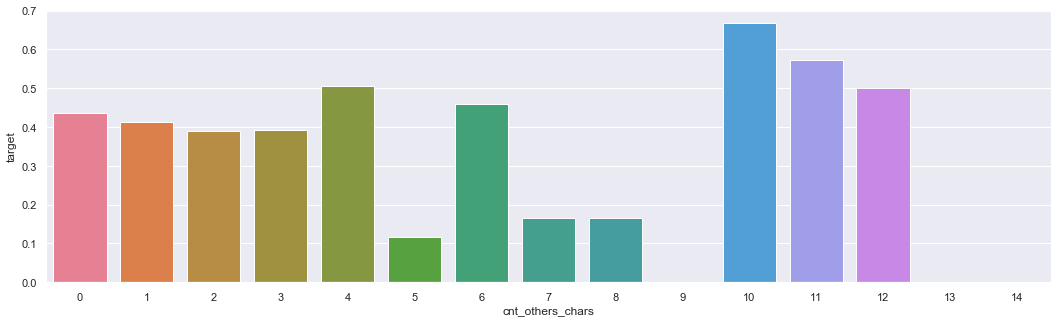

In [37]:
tmp = train_df.groupby(nm).agg('mean').reset_index()
plt.figure(figsize=(18,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count other upper

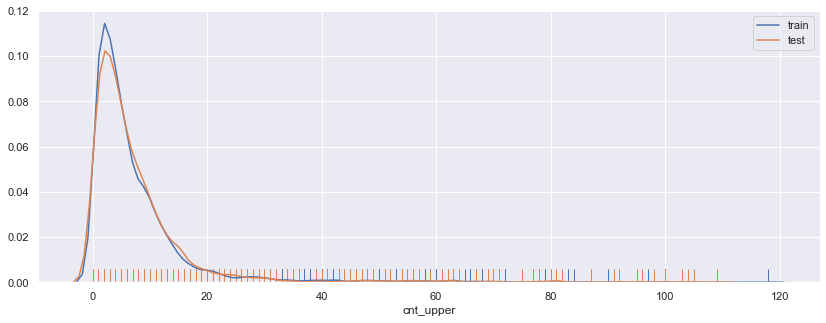

In [38]:
nm = 'cnt_upper'
def cnt_upper(string) -> int:
    return sum(list(map(lambda s: 1 if s.isupper() else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_upper)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

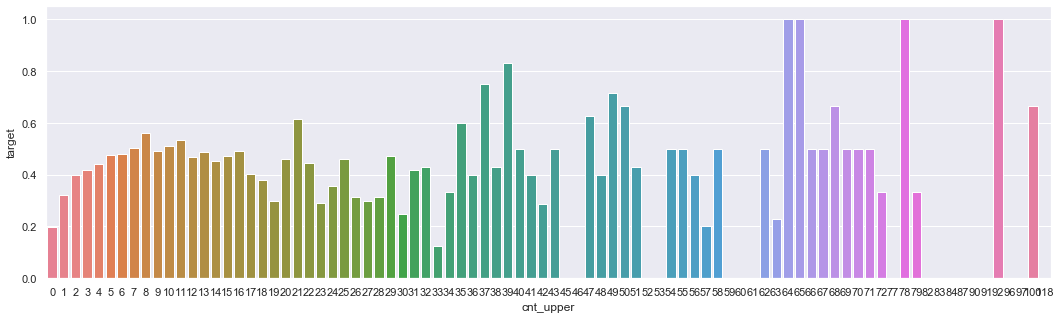

In [39]:
tmp = train_df.groupby(nm).agg('mean').reset_index()
plt.figure(figsize=(18,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Count exclamatory in tweets

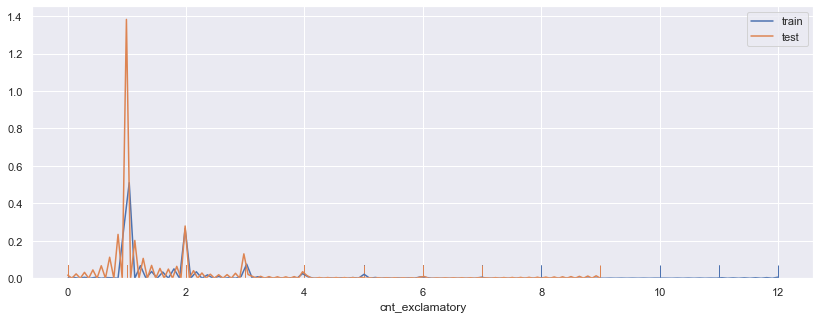

In [40]:
nm = 'cnt_exclamatory'

def cnt_exclamatory(string) -> int:
    return sum(list(map(lambda s: 1 if s == '!' else 0, string)))

for df_ in (train_df, test_df):
    df_[nm] = df_['text'].apply(cnt_exclamatory)

plt.figure(figsize=(14,5))
sns.distplot(train_df[nm], hist=False, rug=True, label="train");
sns.distplot(test_df[nm], hist=False, rug=True, label="test");
plt.legend();

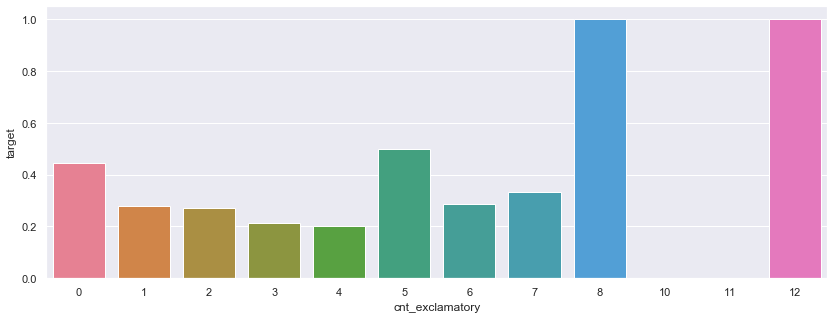

In [41]:
tmp = train_df.groupby(nm).agg('mean')['target'].reset_index()
plt.figure(figsize=(14,5))
fig = sns.barplot(x=tmp[nm], y=tmp['target'], palette="husl")

# Words length stats in tweet:
- median len
- min len
- max len
- std len

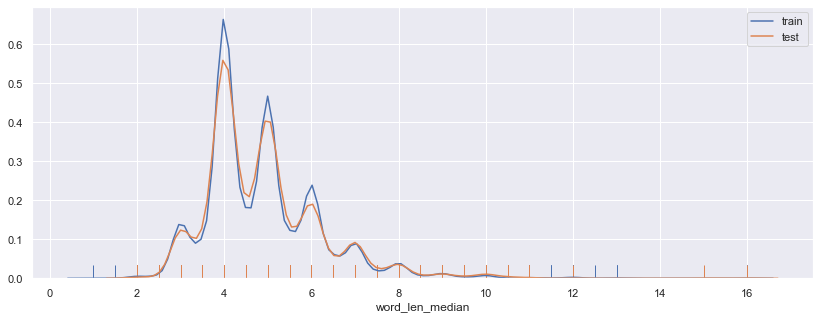

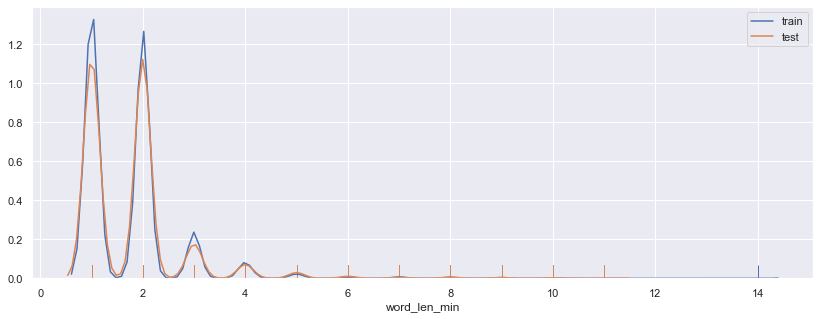

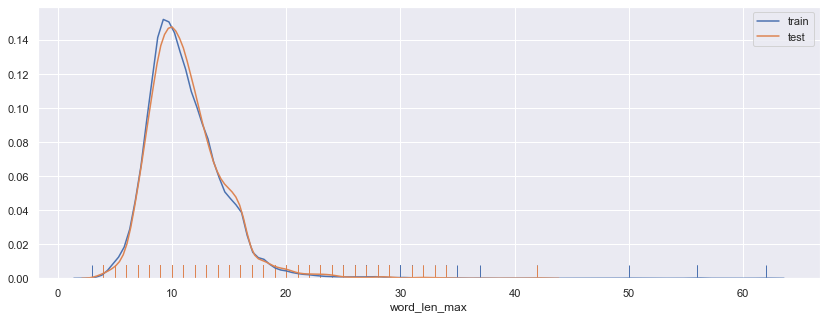

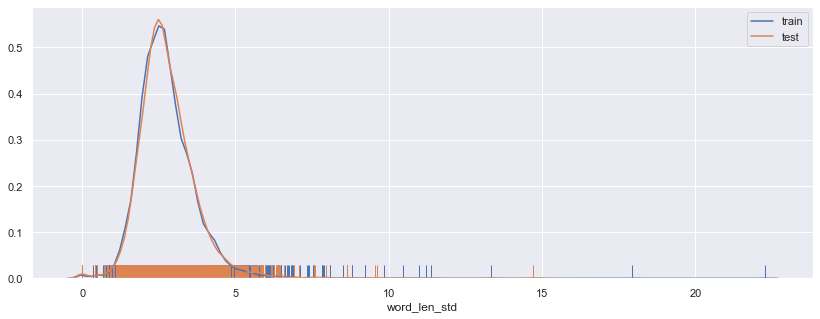

In [42]:
def words_len_stats(string) -> list:
    tmp = np.array(list(map(lambda s: len(s), string.split())))
    return pd.Series([np.median(tmp), np.min(tmp), np.max(tmp), np.std(tmp)])
    
for df_ in (train_df, test_df):
    df_[['word_len_median', 'word_len_min', 'word_len_max', 'word_len_std', ]] = df_['text'].apply(words_len_stats)

for c in ['word_len_median', 'word_len_min', 'word_len_max', 'word_len_std', ]:
    plt.figure(figsize=(14,5))
    sns.distplot(train_df[c], hist=False, rug=True, label="train");
    sns.distplot(test_df[c], hist=False, rug=True, label="test");
    plt.legend()
    plt.show();

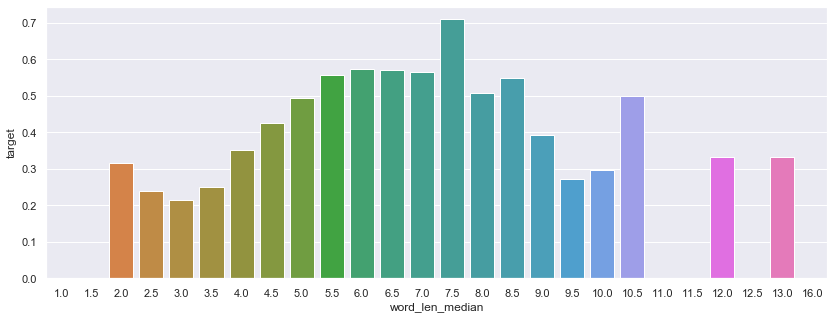

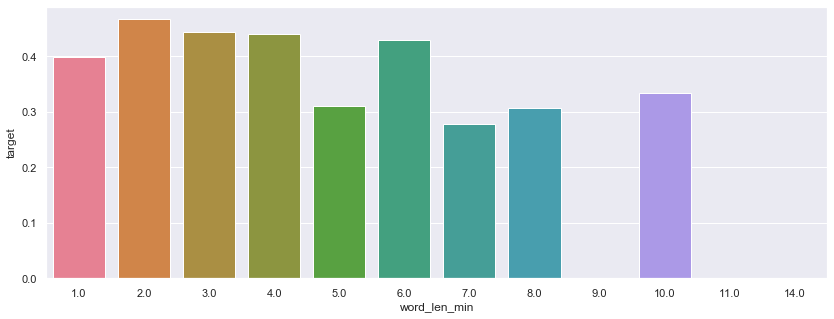

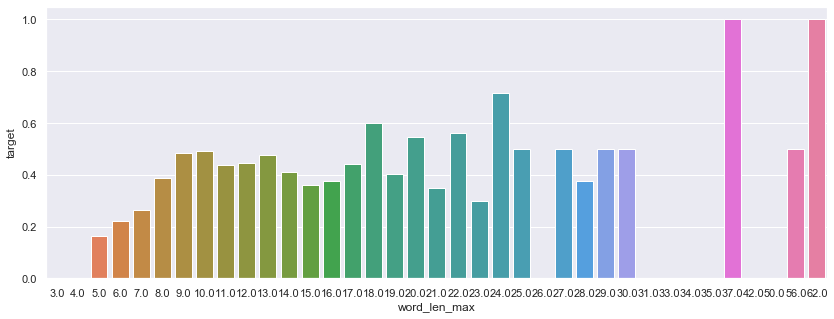

In [43]:
for c in ['word_len_median', 'word_len_min', 'word_len_max']:
    tmp = train_df.groupby(c).agg('mean')['target'].reset_index()
    plt.figure(figsize=(14,5))
    fig = sns.barplot(x=tmp[c], y=tmp['target'], palette="husl")
    plt.show();

In [44]:
train_df.head()

,keyword,location,text,target,link_flg,cnt_len,cnt_users,cnt_hashtags,cnt_punctuation,cnt_whitespace,cnt_numeral,cnt_others_chars,cnt_upper,cnt_exclamatory,word_len_median,word_len_min,word_len_max,word_len_std
0,0.679434,0.424195,Our Deeds are the Reason of this #earthquake M...,1,0,69,0,1,0,12,0,0,10,0,3.0,2.0,11.0,2.403154
1,0.679434,0.424195,Forest fire near La Ronge Sask. Canada,1,0,38,0,0,1,6,0,0,5,0,5.0,2.0,6.0,1.293626
2,0.679434,0.424195,All residents asked to 'shelter in place' are ...,1,0,133,0,0,3,21,0,0,2,0,5.0,2.0,10.0,2.661324
3,0.679434,0.424195,"13,000 people receive #wildfires evacuation or...",1,0,65,0,1,1,8,5,0,1,0,6.5,2.0,10.0,2.619041
4,0.679434,0.424195,Just got sent this photo from Ruby #Alaska as ...,1,0,88,0,2,0,16,0,0,3,0,4.0,1.0,10.0,1.968502


# Some additional features
* with div tweet diff length

In [45]:
train_df['cnt_punct_num_div_len'] = (train_df['cnt_punctuation'] + train_df['cnt_numeral'])**2 / train_df['cnt_len']
train_df['cnt_users_hasht_div_len'] = (train_df['cnt_users'] + train_df['cnt_hashtags'])**2 / train_df['cnt_len']
train_df['cnt_upper_div_len'] = train_df['cnt_upper']**2 / train_df['cnt_len']
train_df['cnt_whitespace_div_len'] = train_df['cnt_whitespace']**2 / train_df['cnt_len']
train_df['cnt_len_median_div_len'] = train_df['word_len_median']**2 / train_df['cnt_len']
train_df['cnt_len_min_div_len'] = train_df['word_len_min']**2 / train_df['cnt_len']
train_df['cnt_len_max_div_len'] = train_df['word_len_max']**2 / train_df['cnt_len'] 
train_df['cnt_len_std_div_len'] = train_df['word_len_std']**2 / train_df['cnt_len'] 

test_df['cnt_punct_num_div_len'] = (test_df['cnt_punctuation'] + test_df['cnt_numeral'])**2 / test_df['cnt_len']
test_df['cnt_users_hasht_div_len'] = (test_df['cnt_users'] + test_df['cnt_hashtags'])**2 / test_df['cnt_len']
test_df['cnt_upper_div_len'] = test_df['cnt_upper']**2 / test_df['cnt_len']
test_df['cnt_whitespace_div_len'] = test_df['cnt_whitespace']**2 / test_df['cnt_len']
test_df['cnt_len_median_div_len'] = test_df['word_len_median']**2 / test_df['cnt_len']
test_df['cnt_len_min_div_len'] = test_df['word_len_min']**2 / test_df['cnt_len']
test_df['cnt_len_max_div_len'] = test_df['word_len_max']**2 / test_df['cnt_len']
test_df['cnt_len_std_div_len'] = test_df['word_len_std']**2 / test_df['cnt_len'] 

# SMS Slang clear
- https://github.com/rishabhverma17/sms_slang_translator/blob/master/slang.txt
- https://www.kaggle.com/rftexas/text-only-kfold-bert

In [46]:
abbreviations = {
    "$" : " dollar ", "€" : " euro ", "4ao" : "for adults only", "a.m" : "before midday", 
    "a3" : "anytime anywhere anyplace", "aamof" : "as a matter of fact", "acct" : "account", 
    "adih" : "another day in hell", "afaic" : "as far as i am concerned", "ave." : "avenue",
    "afaict" : "as far as i can tell", "afaik" : "as far as i know", 
    "afair" : "as far as i remember", "afk" : "away from keyboard", "app" : "application", 
    "approx" : "approximately", "apps" : "applications","atk" : "at the keyboard", 
    "asap" : "as soon as possible", "asl" : "age, sex, location", "ayor" : "at your own risk", 
    "aymm" : "are you my mother", "b&b" : "bed and breakfast", "b+b" : "bed and breakfast",
    "b.c" : "before christ", "b2b" : "business to business", "b2c" : "business to customer", 
    "b4" : "before", "b4n" : "bye for now", "b@u" : "back at you", "bae" : "before anyone else", 
    "bak" : "back at keyboard", "bbbg" : "bye bye be good", "bbc" : "british broadcasting corporation", 
    "bbias" : "be back in a second", "bbl" : "be back later", "bbs" : "be back soon", "be4" : "before", 
    "bfn" : "bye for now", "blvd" : "boulevard", "bout" : "about", "brb" : "be right back", 
    "bros" : "brothers", "brt" : "be right there", "bsaaw" : "big smile and a wink",
    "btw" : "by the way", "bwl" : "bursting with laughter", "c/o" : "care of", 
    "cet" : "central european time", "cf" : "compare", "cia" : "central intelligence agency", 
    "csl" : "can not stop laughing", "cu" : "see you", "cul8r" : "see you later", 
    "cv" : "curriculum vitae", "cwot" : "complete waste of time", "cya" : "see you",
    "cyt" : "see you tomorrow", "dae" : "does anyone else", "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself", "dm" : "direct message", "dwh" : "during work hours", 
    "e123" : "easy as one two three", "eet" : "eastern european time", "eg" : "example", 
    "embm" : "early morning business meeting", "encl" : "enclosed", "encl." : "enclosed", 
    "etc" : "and so on", "faq" : "frequently asked questions", "fawc" : "for anyone who cares",
    "fb" : "facebook", "fc" : "fingers crossed", "fig" : "figure", "fimh" : "forever in my heart", 
    "ft." : "feet", "ft" : "featuring", "ftl" : "for the loss", "ftw" : "for the win", 
    "fwiw" : "for what it is worth", "fyi" : "for your information", "g9" : "genius", 
    "gahoy" : "get a hold of yourself", "gal" : "get a life", "gfn" : "gone for now", 
    "gg" : "good game", "gl" : "good luck", "glhf" : "good luck have fun", 
    "gmta" : "great minds think alike", "gn" : "good night", "g.o.a.t" : "greatest of all time", 
    "goat" : "greatest of all time", "goi" : "get over it", "gmt" : "greenwich mean time", 
    "gcse" : "general certificate of secondary education", "gps" : "global positioning system", 
    "gr8" : "great", "gratz" : "congratulations", "gyal" : "girl", "h&c" : "hot and cold",
    "hp" : "horsepower", "hr" : "hour", "hrh" : "his royal highness", "ht" : "height", 
    "ibrb" : "i will be right back", "ic" : "i see", "icq" : "i seek you", 
    "icymi" : "in case you missed it", "idc" : "i do not care", "idgadf" : "i do not give a damn fuck", 
    "idgaf" : "i do not give a fuck", "idk" : "i do not know", "ie" : "that is", "i.e" : "that is", 
    "ifyp" : "i feel your pain", "IG" : "instagram", "iirc" : "if i remember correctly",
    "ilu" : "i love you", "ily" : "i love you", "imho" : "in my humble opinion", 
    "imo" : "in my opinion", "imu" : "i miss you", "iow" : "in other words", "irl" : "in real life", 
    "j4f" : "just for fun", "jic" : "just in case", "jk" : "just kidding",
    "jsyk" : "just so you know", "l8r" : "later", "lb" : "pound", "lbs" : "pounds", 
    "ldr" : "long distance relationship", "lmao" : "laugh my ass off", 
    "lmfao" : "laugh my fucking ass off", "lol" : "laughing out loud", "ltd" : "limited",
    "ltns" : "long time no see", "m8" : "mate", "mf" : "motherfucker", "mfs" : "motherfuckers", 
    "mfw" : "my face when", "mofo" : "motherfucker", "mph" : "miles per hour", "mr" : "mister", 
    "mrw" : "my reaction when", "ms" : "miss", "mte" : "my thoughts exactly", "nagi" : "not a good idea", 
    "nbc" : "national broadcasting company", "nbd" : "not big deal", "nfs" : "not for sale", 
    "ngl" : "not going to lie", "nhs" : "national health service", "nrn" : "no reply necessary", 
    "nsfl" : "not safe for life", "nsfw" : "not safe for work", "nth" : "nice to have",
    "nvr" : "never", "nyc" : "new york city", "oc" : "original content", "og" : "original", 
    "ohp" : "overhead projector", "oic" : "oh i see", "omdb" : "over my dead body", "omg" : "oh my god", 
    "omw" : "on my way", "p.a" : "per annum", "p.m" : "after midday",  "pm" : "prime minister", 
    "poc" : "people of color", "pov" : "point of view", "pp" : "pages", "ppl" : "people", 
    "prw" : "parents are watching", "ps" : "postscript", "pt" : "point", "ptb" : "please text back",
    "pto" : "please turn over", "qpsa" : "what happens", "ratchet" : "rude", 
    "rbtl" : "read between the lines", "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing", "ruok" : "are you ok", 
    "roflol" : "rolling on the floor laughing out loud", "rt" : "retweet",
    "rotflmao" : "rolling on the floor laughing my ass off", "sfw" : "safe for work",
    "sk8" : "skate", "smh" : "shake my head", "sq" : "square", "srsly" : "seriously", 
    "ssdd" : "same stuff different day", "tbh" : "to be honest", "tbs" : "tablespooful", 
    "tbsp" : "tablespooful", "tfw" : "that feeling when", "thks" : "thank you",
    "tho" : "though", "thx" : "thank you", "tia" : "thanks in advance", "til" : "today i learned", 
    "tl;dr" : "too long i did not read", "tldr" : "too long i did not read", "tmb" : "tweet me back", 
    "tntl" : "trying not to laugh", "ttyl" : "talk to you later", "u" : "you", "u2" : "you too", 
    "u4e" : "yours for ever", "utc" : "coordinated universal time", "w/" : "with", "w/o" : "without", 
    "w8" : "wait", "wassup" : "what is up", "wb" : "welcome back", "wtf" : "what the fuck", 
    "wtg" : "way to go", "wtpa" : "where the party at", "wuf" : "where are you from", 
    "wuzup" : "what is up", "wywh" : "wish you were here", "yd" : "yard", "ygtr" : "you got that right", 
    "ynk" : "you never know", "zzz" : "sleeping bored and tired" }

In [47]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def convert_abbrev_in_text(text):
    tokenizer = WordPunctTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

train_df["text"] = train_df["text"].apply(lambda x: convert_abbrev_in_text(x))
test_df["text"] = test_df["text"].apply(lambda x: convert_abbrev_in_text(x))

# TEXT Normalization
Definition: The jargon used in coloquial language, specially in social media, leads to either content not useful for NLP or to different versions of the same sentence but written in alternative ways. For example: punctuation marks, emojis, contractions, URLs, grammar errors...

To normalize data and reduce noise, we will apply several transformations:

- Remove emojis. Despite emojis are related to sentiments, they are abused and used in any type of tweet.
- Remove punctuation. All punctuation marks are deleted.
- Spell checking. Substitute wrong sentences (Am gona ned you) to correct ones (I am going to need you).


Disclaimer: the origin of several of the functions used in this subsection come from the awesome kernel of Shahules786; https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove. Please check it out for reckon.

In [48]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

# Now compact all the normalization function calls into a single function
def normalization(text):
    text = remove_emoji(text)
    text = remove_punct(text)
    text = correct_spellings(text)
    return text

In [49]:
%%time
train_df['text'] = train_df['text'].apply(normalization)
test_df['text'] = test_df['text'].apply(normalization)

Wall time: 45min 43s


# Text preprocessing with NLTK
- WordPunctTokenizer
- stopwords delete

In [50]:
tokenizer = WordPunctTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "tweet you" with "Ok, great!!!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "tweet you" with "Ok, great!!!".
after: how to be a grown - up at work : replace " tweet you " with " ok , great !!!".


In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Des\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
stop_words = set(stopwords.words('english'))
stop_words_filter = lambda text: ' '.join([t for t in text.split() if t not in stop_words])
print("before:", text,)
print("after:", stop_words_filter(preprocess(text)),)

before: How to be a grown-up at work: replace "tweet you" with "Ok, great!!!".
after: grown - work : replace " tweet " " ok , great !!!".


### Preprocess each tweet in train and test:

In [53]:
%%time
texts_train = list(map(lambda text: stop_words_filter(preprocess(text)), train_df['text']))
texts_test = list(map(lambda text: stop_words_filter(preprocess(text)), test_df['text']))
assert len(texts_train) == len(train_df)
assert len(texts_test) == len(test_df)

Wall time: 96 ms


# Words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature with tf-idf for some classifier

In [54]:
import collections
k = 3750
c = collections.Counter()

for sentence in texts_train:
    for word in tokenizer.tokenize(sentence):
        c[word] += 1

bow_vocabulary = list([i[0] for i in c.most_common(k)])
print('example features:', sorted(bow_vocabulary)[::500])

example features: ['-', 'break', 'disgusting', 'group', 'lou', 'played', 'sink', 'upon']


# Manual tf-idf without SKLEARN
- Calculate bow vocabulary

In [55]:
def text_to_bow(text) -> np.array:
    """ convert text string to an array of token counts. Use bow_vocabulary. """
    bow = bow_vocabulary
    tmp = []
    for ch_bow in bow:
        val = 0
        for ttk in tokenizer.tokenize(text):
            if ch_bow == ttk:
                val += 1
        tmp.append(val)
    
    return np.array(tmp, 'float32')

In [56]:
%%time
X_train_bow = np.stack(list(map(text_to_bow, texts_train)))
X_test_bow = np.stack(list(map(text_to_bow, texts_test)))

Wall time: 2min 32s


In [57]:
X_train_bow[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### WordCloud for tweets

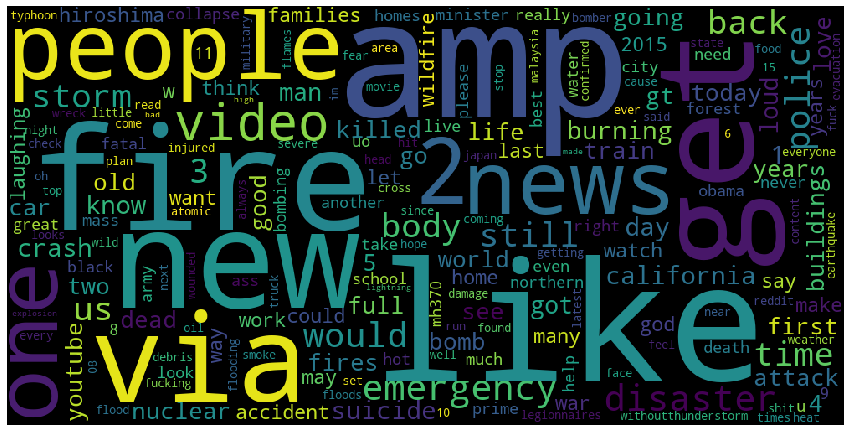

In [58]:
#convert country names to dictionary with values and its occurences
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(c)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }} $$


, where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

In [59]:
def tf_idf_calc(txt, bow: list) -> dict:
    d = {}
    n_txt = len(txt)
    for word in bow:
        cnt = 0
        for sent in txt:
            if word in set(tokenizer.tokenize(sent)):
                cnt += 1
        d[word] = np.log(n_txt / (cnt + 1))
    return d

In [60]:
%%time
tf_idf_dict_train = tf_idf_calc(texts_train, bow_vocabulary)

Wall time: 1min 57s


In [61]:
def tf_idf(df, d) -> list:
    df_ = []
    for bag in df:
        tmp = []
        for n_word in range(len(bag)):
            tmp.append(bag[n_word] * d[bow_vocabulary[n_word]])
        df_.append(tmp)
    return df_

In [62]:
%%time
X_train_tf_idf = pd.DataFrame(tf_idf(X_train_bow, tf_idf_dict_train))
X_test_tf_idf = pd.DataFrame(tf_idf(X_test_bow, tf_idf_dict_train))

Wall time: 1min 39s


# Get target

In [63]:
y = train_df['target']
train_df.drop(['target'], axis=1, inplace=True)

In [64]:
y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [65]:
y.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

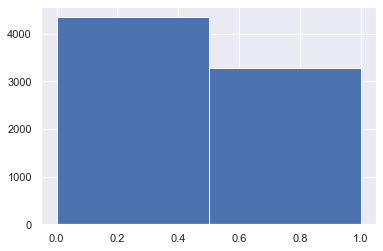

In [66]:
y.hist(bins=y.nunique());

# Truncated SVD for logistic regression 

In [67]:
X_train_tf_idf.shape

(7613, 3750)

### At this stage we choose the optimal decomposition. We introduce the metric for this step:

$$ penalty = { [(F_1(train) - F_1(test))^2]^P } $$
$$ bestSVD = { argmax[F_1(test) - penalty ] } $$


In [68]:
%%time
cols = X_train_tf_idf.shape[1]
# SVD step
step = 20
# different between train and test penalty:
p = 0.6

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=777)
w=[]

for n_svd in range(X_train_tf_idf.shape[1]-step, 0, -step):
    tmp_w = []
    for train_index, val_index in skf.split(X_train_tf_idf, y):
        x_train, x_valid = X_train_tf_idf.iloc[train_index, :], X_train_tf_idf.iloc[val_index, :]
        y_train, y_valid = y[train_index], y[val_index]
        
        svd = TruncatedSVD(n_components=n_svd).fit(x_train)
        x_train_svd = svd.transform(x_train)
        x_valid_svd = svd.transform(x_valid)
        
        tf_idf_model = LogisticRegression().fit(x_train_svd, y_train)
        svd_train = f1_score(y_train, tf_idf_model.predict(x_train_svd))
        svd_valid = f1_score(y_valid, tf_idf_model.predict(x_valid_svd))
        tmp_w.append([svd_train, svd_valid])
        
    mn = np.mean(tmp_w, axis=0)
    train = mn[0]
    test = mn[1]
    w.append([n_svd, train, test, np.power(np.square(train-test), p), +test-np.power(np.square(train-test), p)])

Wall time: 4h 11min 35s


In [69]:
svd_valid = pd.DataFrame(w, columns=['n_svd', 'train', 'test', 'diff', 'result'])

In [70]:
svd_valid

,n_svd,train,test,diff,result
0,3730,0.976363,0.700987,0.212770,0.488217
1,3710,0.976363,0.700987,0.212770,0.488217
2,3690,0.976363,0.700987,0.212770,0.488217
3,3670,0.976363,0.700987,0.212770,0.488217
4,3650,0.976363,0.700987,0.212770,0.488217
5,3630,0.976363,0.700987,0.212770,0.488217
6,3610,0.976360,0.700987,0.212768,0.488220
7,3590,0.976363,0.700987,0.212770,0.488217
8,3570,0.976360,0.701191,0.212578,0.488613
9,3550,0.976360,0.701718,0.212090,0.489629


### Best number Truncated SVD is:

In [71]:
svd_valid[svd_valid.index == svd_valid['result'].argmax()]

,n_svd,train,test,diff,result
169,350,0.77776,0.734747,0.022926,0.711821


In [72]:
n_svd = svd_valid[svd_valid.index == svd_valid['result'].argmax()].iloc[0, 0]

### Transform tf-idf  matrix with Truncated SVD

In [73]:
%%time
svd = TruncatedSVD(n_components=n_svd).fit(X_train_tf_idf)
X_train_svd = svd.transform(X_train_tf_idf)
X_test_svd = svd.transform(X_test_tf_idf)

Wall time: 4.52 s


In [74]:
train_df.drop('text', inplace=True, axis=1)
test_df.drop('text', inplace=True, axis=1)

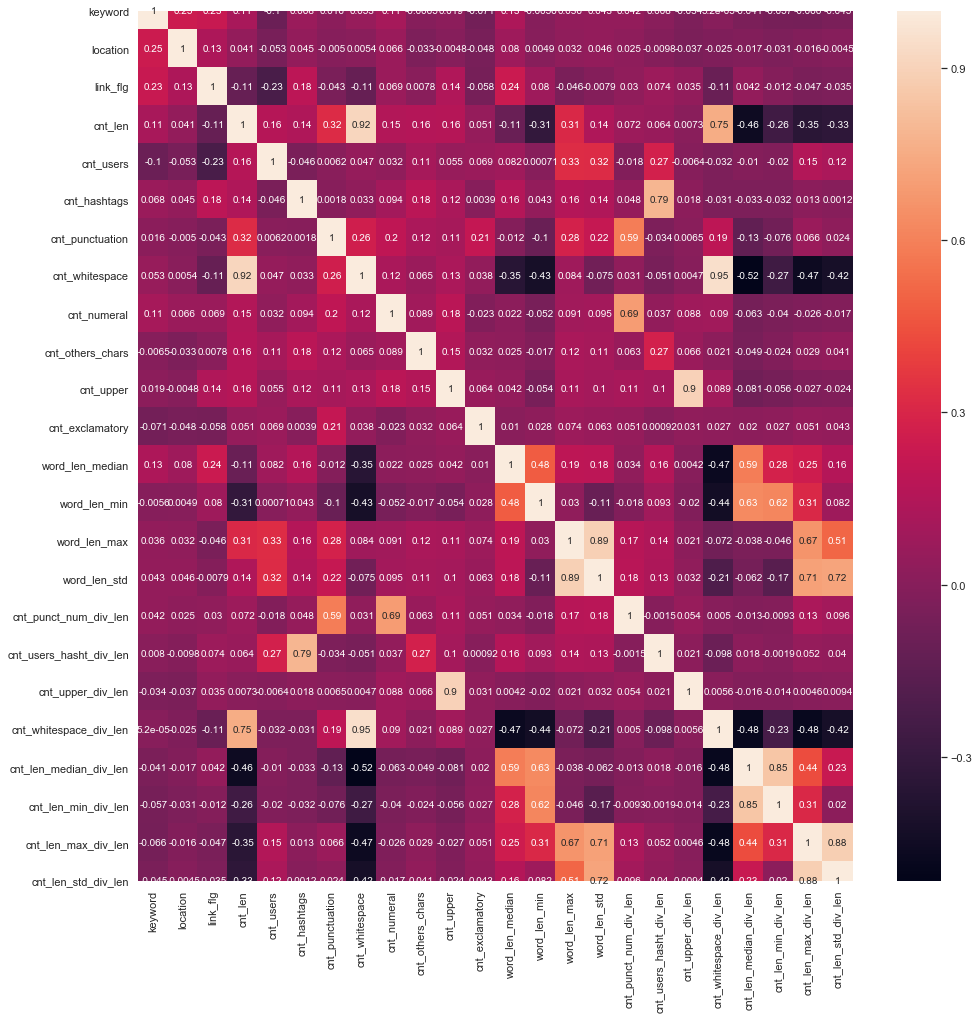

In [75]:
train_corr = train_df.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(train_corr, xticklabels=train_corr.columns, yticklabels=train_corr.columns, annot=True, ax=ax);

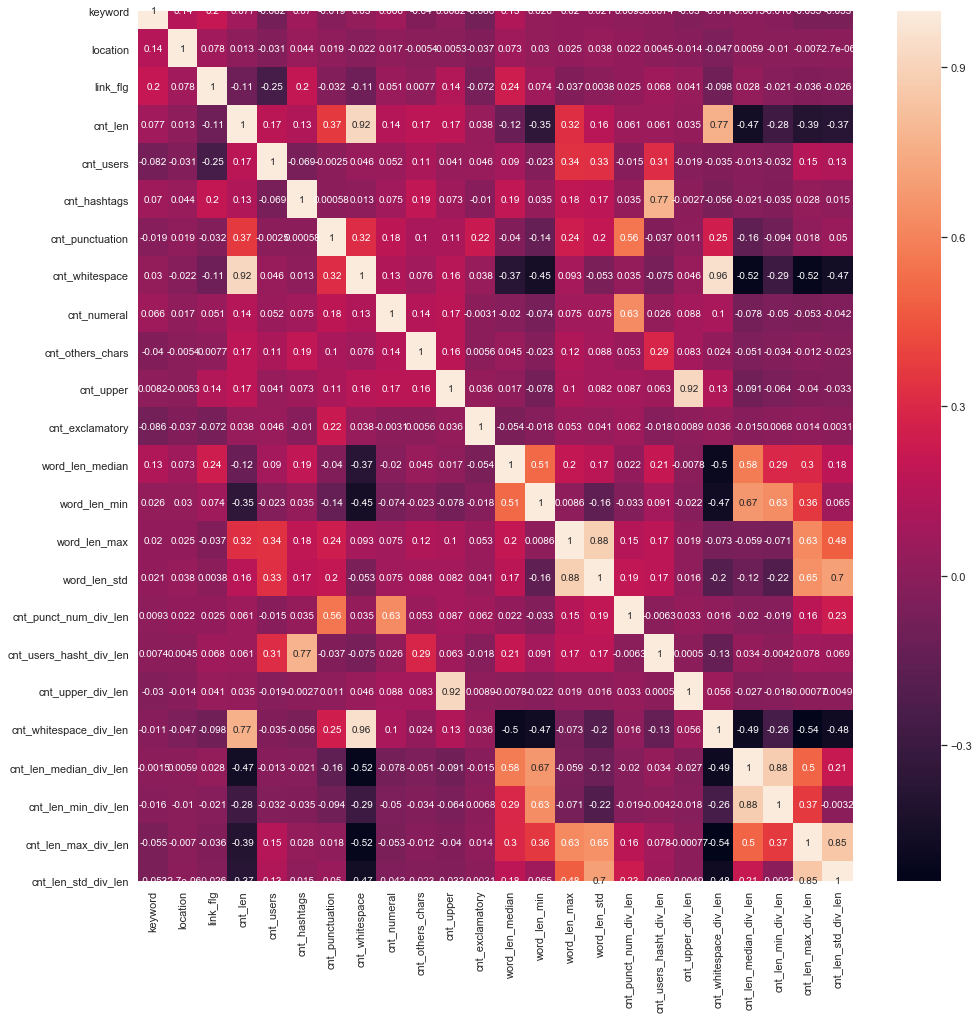

In [76]:
test_corr = test_df.corr()
# plot the heatmap and annotation on it
fig, ax = plt.subplots(figsize=(16,16))
sns.heatmap(test_corr, xticklabels=test_corr.columns, yticklabels=test_corr.columns, annot=True, ax=ax);

# Drop columns with high correlation

In [151]:
drop_cols = ['cnt_len', 'cnt_hashtags', 'cnt_whitespace', 'cnt_upper', 'word_len_min', 'word_len_max', 'word_len_std',]

# Stack it

In [154]:
train_df[['svd_'+str(c) for c in range(X_train_svd.shape[1])]] = pd.DataFrame(X_train_svd)
test_df[['svd_'+str(c) for c in range(X_test_svd.shape[1])]] = pd.DataFrame(X_test_svd)

# Check it

In [155]:
train_df.head()

,keyword,location,link_flg,cnt_len,cnt_users,cnt_hashtags,cnt_punctuation,cnt_whitespace,cnt_numeral,cnt_others_chars,cnt_upper,cnt_exclamatory,word_len_median,word_len_min,word_len_max,word_len_std,cnt_punct_num_div_len,cnt_users_hasht_div_len,cnt_upper_div_len,cnt_whitespace_div_len,cnt_len_median_div_len,cnt_len_min_div_len,cnt_len_max_div_len,cnt_len_std_div_len,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,svd_31,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49,svd_50,svd_51,svd_52,svd_53,svd_54,svd_55,svd_56,svd_57,svd_58,svd_59,svd_60,svd_61,svd_62,svd_63,svd_64,svd_65,svd_66,svd_67,svd_68,svd_69,svd_70,svd_71,svd_72,svd_73,svd_74,svd_75,svd_76,svd_77,svd_78,svd_79,svd_80,svd_81,svd_82,svd_83,svd_84,svd_85,svd_86,svd_87,svd_88,svd_89,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,svd_100,svd_101,svd_102,svd_103,svd_104,svd_105,svd_106,svd_107,svd_108,svd_109,svd_110,svd_111,svd_112,svd_113,svd_114,svd_115,svd_116,svd_117,svd_118,svd_119,svd_120,svd_121,svd_122,svd_123,svd_124,svd_125,svd_126,svd_127,svd_128,svd_129,svd_130,svd_131,svd_132,svd_133,svd_134,svd_135,svd_136,svd_137,svd_138,svd_139,svd_140,svd_141,svd_142,svd_143,svd_144,svd_145,svd_146,svd_147,svd_148,svd_149,svd_150,svd_151,svd_152,svd_153,svd_154,svd_155,svd_156,svd_157,svd_158,svd_159,svd_160,svd_161,svd_162,svd_163,svd_164,svd_165,svd_166,svd_167,svd_168,svd_169,svd_170,svd_171,svd_172,svd_173,svd_174,svd_175,svd_176,svd_177,svd_178,svd_179,svd_180,svd_181,svd_182,svd_183,svd_184,svd_185,svd_186,svd_187,svd_188,svd_189,svd_190,svd_191,svd_192,svd_193,svd_194,svd_195,svd_196,svd_197,svd_198,svd_199,svd_200,svd_201,svd_202,svd_203,svd_204,svd_205,svd_206,svd_207,svd_208,svd_209,svd_210,svd_211,svd_212,svd_213,svd_214,svd_215,svd_216,svd_217,svd_218,svd_219,svd_220,svd_221,svd_222,svd_223,svd_224,svd_225,svd_226,svd_227,svd_228,svd_229,svd_230,svd_231,svd_232,svd_233,svd_234,svd_235,svd_236,svd_237,svd_238,svd_239,svd_240,svd_241,svd_242,svd_243,svd_244,svd_245,svd_246,svd_247,svd_248,svd_249,svd_250,svd_251,svd_252,svd_253,svd_254,svd_255,svd_256,svd_257,svd_258,svd_259,svd_260,svd_261,svd_262,svd_263,svd_264,svd_265,svd_266,svd_267,svd_268,svd_269,svd_270,svd_271,svd_272,svd_273,svd_274,svd_275,svd_276,svd_277,svd_278,svd_279,svd_280,svd_281,svd_282,svd_283,svd_284,svd_285,svd_286,svd_287,svd_288,svd_289,svd_290,svd_291,svd_292,svd_293,svd_294,svd_295,svd_296,svd_297,svd_298,svd_299,svd_300,svd_301,svd_302,svd_303,svd_304,svd_305,svd_306,svd_307,svd_308,svd_309,svd_310,svd_311,svd_312,svd_313,svd_314,svd_315,svd_316,svd_317,svd_318,svd_319,svd_320,svd_321,svd_322,svd_323,svd_324,svd_325,svd_326,svd_327,svd_328,svd_329,svd_330,svd_331,svd_332,svd_333,svd_334,svd_335,svd_336,svd_337,svd_338,svd_339,svd_340,svd_341,svd_342,svd_343,svd_344,svd_345,svd_346,svd_347,svd_348,svd_349
0,0.679434,0.424195,0,69,0,1,0,12,0,0,10,0,3.0,2.0,11.0,2.403154,0.000000,0.014493,1.449275,2.086957,0.130435,0.057971,1.753623,0.083698,0.706773,-0.369695,-0.355019,-0.384842,0.385495,-0.193318,0.012022,-0.122918,-0.272335,-0.126671,0.054348,0.063108,-0.113084,-0.068640,-0.029651,-0.050122,0.107303,-0.367111,0.301821,-0.069530,-0.005065,0.007934,0.948238,1.362975,-0.133705,-0.162075,-0.057734,-0.282182,-0.119807,-0.147449,0.102383,-0.060087,0.062681,0.037708,-0.124358,-0.089801,-0.066361,0.244550,0.106361,0.046137,0.135533,0.329878,0.097415,0.289565,0.248726,0.089735,-0.182243,-0.297090,-0.002388,-0.373771,-0.226957,-0.065577,0.089954,-0.085167,-0.123518,-0.331469,-0.025524,-0.106711,-0.189462,0.382583,0.527870,-0.001422,-0.655027,0.110695,0.188063,-0.280083,-0.346245,-0.942045,0.533641,-0.427086,-0.302753,-0.155730,0.353551,-0.832513,0.220961,1.579011,0.129765,0.206857,-0.506313,-0.524801,0.449034,1.618811,0.578644,1.405569,0

In [156]:
test_df.head()

,keyword,location,link_flg,cnt_len,cnt_users,cnt_hashtags,cnt_punctuation,cnt_whitespace,cnt_numeral,cnt_others_chars,cnt_upper,cnt_exclamatory,word_len_median,word_len_min,word_len_max,word_len_std,cnt_punct_num_div_len,cnt_users_hasht_div_len,cnt_upper_div_len,cnt_whitespace_div_len,cnt_len_median_div_len,cnt_len_min_div_len,cnt_len_max_div_len,cnt_len_std_div_len,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,svd_31,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49,svd_50,svd_51,svd_52,svd_53,svd_54,svd_55,svd_56,svd_57,svd_58,svd_59,svd_60,svd_61,svd_62,svd_63,svd_64,svd_65,svd_66,svd_67,svd_68,svd_69,svd_70,svd_71,svd_72,svd_73,svd_74,svd_75,svd_76,svd_77,svd_78,svd_79,svd_80,svd_81,svd_82,svd_83,svd_84,svd_85,svd_86,svd_87,svd_88,svd_89,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,svd_100,svd_101,svd_102,svd_103,svd_104,svd_105,svd_106,svd_107,svd_108,svd_109,svd_110,svd_111,svd_112,svd_113,svd_114,svd_115,svd_116,svd_117,svd_118,svd_119,svd_120,svd_121,svd_122,svd_123,svd_124,svd_125,svd_126,svd_127,svd_128,svd_129,svd_130,svd_131,svd_132,svd_133,svd_134,svd_135,svd_136,svd_137,svd_138,svd_139,svd_140,svd_141,svd_142,svd_143,svd_144,svd_145,svd_146,svd_147,svd_148,svd_149,svd_150,svd_151,svd_152,svd_153,svd_154,svd_155,svd_156,svd_157,svd_158,svd_159,svd_160,svd_161,svd_162,svd_163,svd_164,svd_165,svd_166,svd_167,svd_168,svd_169,svd_170,svd_171,svd_172,svd_173,svd_174,svd_175,svd_176,svd_177,svd_178,svd_179,svd_180,svd_181,svd_182,svd_183,svd_184,svd_185,svd_186,svd_187,svd_188,svd_189,svd_190,svd_191,svd_192,svd_193,svd_194,svd_195,svd_196,svd_197,svd_198,svd_199,svd_200,svd_201,svd_202,svd_203,svd_204,svd_205,svd_206,svd_207,svd_208,svd_209,svd_210,svd_211,svd_212,svd_213,svd_214,svd_215,svd_216,svd_217,svd_218,svd_219,svd_220,svd_221,svd_222,svd_223,svd_224,svd_225,svd_226,svd_227,svd_228,svd_229,svd_230,svd_231,svd_232,svd_233,svd_234,svd_235,svd_236,svd_237,svd_238,svd_239,svd_240,svd_241,svd_242,svd_243,svd_244,svd_245,svd_246,svd_247,svd_248,svd_249,svd_250,svd_251,svd_252,svd_253,svd_254,svd_255,svd_256,svd_257,svd_258,svd_259,svd_260,svd_261,svd_262,svd_263,svd_264,svd_265,svd_266,svd_267,svd_268,svd_269,svd_270,svd_271,svd_272,svd_273,svd_274,svd_275,svd_276,svd_277,svd_278,svd_279,svd_280,svd_281,svd_282,svd_283,svd_284,svd_285,svd_286,svd_287,svd_288,svd_289,svd_290,svd_291,svd_292,svd_293,svd_294,svd_295,svd_296,svd_297,svd_298,svd_299,svd_300,svd_301,svd_302,svd_303,svd_304,svd_305,svd_306,svd_307,svd_308,svd_309,svd_310,svd_311,svd_312,svd_313,svd_314,svd_315,svd_316,svd_317,svd_318,svd_319,svd_320,svd_321,svd_322,svd_323,svd_324,svd_325,svd_326,svd_327,svd_328,svd_329,svd_330,svd_331,svd_332,svd_333,svd_334,svd_335,svd_336,svd_337,svd_338,svd_339,svd_340,svd_341,svd_342,svd_343,svd_344,svd_345,svd_346,svd_347,svd_348,svd_349
0,0.679434,0.424195,0,34,0,0,0,5,0,0,1,0,4.5,1.0,8.0,2.544056,0.000000,0.000000,0.029412,0.735294,0.595588,0.029412,1.882353,0.190359,0.428178,-0.143302,-0.148660,-0.120181,-0.303277,0.086095,-0.158287,-0.217624,0.291567,-0.037201,0.162571,-0.014119,0.515928,0.189197,0.477089,0.043347,-0.170488,-0.169324,-0.019329,0.426007,-0.295274,0.044671,1.606235,-0.901880,0.776587,1.098332,-0.358198,0.049871,-0.152330,-0.070438,-0.026928,-0.031353,-0.098435,-0.026739,-0.032842,0.009797,0.078067,-0.045283,-0.032297,-0.046285,0.148847,-0.395909,-0.032685,-0.020791,0.047842,-0.111781,-0.506073,0.502384,0.017636,0.041319,-0.405170,0.624612,0.003996,0.048758,-0.221007,-0.273819,0.021667,0.194278,0.001154,-0.014415,0.073878,1.000535,1.103403,0.481948,-0.369127,-0.257857,-0.281079,0.524537,-0.227079,-0.740569,-0.226037,0.378829,-0.372619,-0.521792,-0.105373,-0.259649,0.633007,0.243754,-0.074504,-0.420195,0.312411,-0.106377,-0.625743,0.161761,-0.0

In [157]:
train_df.shape, test_df.shape

((7613, 374), (3263, 374))

# Bland it

In [158]:
%%time
train_scores=[]
test_scores=[]

skf_1 = StratifiedKFold(n_splits=3, shuffle=True, random_state=777)

lr_grid = {"C": [10, 1, 0.5, 0.1, 0.075, 0.06, 0.05, 0.04, 0.25, 0.01, 0.005, 0.001], "penalty":['l1', 'l2']}


for no, (train_index_1, val_index_1) in enumerate(skf_1.split(train_df, y)):
    train_df_ = train_df.drop(drop_cols, axis=1).copy()
    test_df_ = test_df.drop(drop_cols, axis=1).copy()
    x_train_1, x_valid_1 = train_df_.iloc[train_index_1, :], train_df_.iloc[val_index_1, :]
    y_train_1, y_valid_1 = y[train_index_1], y[val_index_1]
    
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg, lr_grid, cv=3, verbose=False, scoring='f1', n_jobs=-1)
    logreg_cv.fit(x_train_1, y_train_1)
    logreg_model = LogisticRegression(**logreg_cv.best_params_).fit(x_train_1, y_train_1)
    train_pred = logreg_model.predict_proba(x_train_1)[:, 1]
    valid_pred = logreg_model.predict_proba(x_valid_1)[:, 1]
    test_pred = logreg_model.predict_proba(test_df_)[:, 1]
    train_scores.append(np.concatenate((train_pred, valid_pred), axis=None))
    test_scores.append(test_pred)
    print('Fold Log: ', no, 'CV F1: ', logreg_cv.best_score_, 'Valid F1: ', f1_score(y_valid_1, logreg_model.predict(x_valid_1)), 
          'Best params: ', logreg_cv.best_params_)

Fold Log:  0 CV F1:  0.7099565624319731 Valid F1:  0.7592592592592592 Best params:  {'C': 0.06, 'penalty': 'l1'}
Fold Log:  1 CV F1:  0.7207030902824597 Valid F1:  0.7561214495592555 Best params:  {'C': 0.075, 'penalty': 'l1'}
Fold Log:  2 CV F1:  0.7380036188445658 Valid F1:  0.7548262548262548 Best params:  {'C': 0.25, 'penalty': 'l1'}
Wall time: 2min 15s


# Predict & submit

In [159]:
sub_df['target'] = list(map(lambda x: 1 if x>=0.5 else 0, np.mean(test_scores, axis=0)))

In [160]:
sub_df['target'].mean()

0.3665338645418327

In [161]:
sub_df.to_csv('main_v8_bland.csv', index=False)